<a href="https://colab.research.google.com/github/liuyixin-louis/dl_learning/blob/master/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 手写数字识别


In [19]:
!pip3 install torch torchvision

In [22]:
import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 64

# list all transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

# download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw





Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


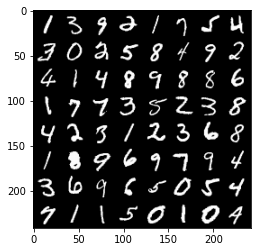

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [0]:
# parameters 
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 10

In [0]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(ImageRNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

In [26]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 28,28))
print(logits[0:10])

tensor([[ 0.0626, -0.0196,  0.0539, -0.0001, -0.0470, -0.0534, -0.0673,  0.0368,
          0.0097, -0.0737],
        [ 0.0688, -0.0213,  0.0636, -0.0075, -0.0419, -0.0467, -0.0895,  0.0303,
          0.0191, -0.0747],
        [ 0.0668,  0.0060,  0.0329, -0.0008, -0.0362, -0.0526, -0.0708,  0.0292,
          0.0068, -0.0733],
        [ 0.0685, -0.0151,  0.0571, -0.0016, -0.0416, -0.0457, -0.0868,  0.0306,
          0.0112, -0.0758],
        [ 0.0627, -0.0160,  0.0535,  0.0034, -0.0470, -0.0486, -0.0703,  0.0343,
          0.0078, -0.0731],
        [ 0.0615, -0.0125,  0.0533,  0.0011, -0.0425, -0.0504, -0.0683,  0.0265,
          0.0078, -0.0739],
        [ 0.0604, -0.0153,  0.0553,  0.0013, -0.0600, -0.0591, -0.0523,  0.0393,
          0.0070, -0.0676],
        [ 0.0834, -0.0327,  0.0482, -0.0006, -0.0362, -0.0588, -0.0526,  0.0265,
          0.0102, -0.0929],
        [ 0.0811,  0.0042,  0.0329, -0.0113, -0.0656, -0.0144, -0.1087,  0.0230,
         -0.0063, -0.0785],
        [ 0.0685, -

In [0]:
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [28]:
for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.6466 | Train Accuracy: 79.57
Epoch:  1 | Loss: 0.3032 | Train Accuracy: 91.12
Epoch:  2 | Loss: 0.2312 | Train Accuracy: 93.46
Epoch:  3 | Loss: 0.1945 | Train Accuracy: 94.44
Epoch:  4 | Loss: 0.1669 | Train Accuracy: 95.42
Epoch:  5 | Loss: 0.1485 | Train Accuracy: 95.89
Epoch:  6 | Loss: 0.1487 | Train Accuracy: 95.80
Epoch:  7 | Loss: 0.1398 | Train Accuracy: 96.08
Epoch:  8 | Loss: 0.1277 | Train Accuracy: 96.41
Epoch:  9 | Loss: 0.1238 | Train Accuracy: 96.59


# 参考

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np

In [0]:

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [11]:


# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../../data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)


Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw


Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw



Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw


Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw
Processing...
Done!


In [0]:
# Recurrent neural network (many-to-one)
class RNN(nn.Module):
  '''
  intput:(batch_size,img_width,img_height)
  output:(batch_size,10)
  '''
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [0]:
# Hyper-parameters
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.01

In [0]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [18]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total)) 

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Epoch [1/2], Step [100/600], Loss: 0.5289
Epoch [1/2], Step [200/600], Loss: 0.2603
Epoch [1/2], Step [300/600], Loss: 0.3730
Epoch [1/2], Step [400/600], Loss: 0.2932
Epoch [1/2], Step [500/600], Loss: 0.1721
Epoch [1/2], Step [600/600], Loss: 0.1873
Epoch [2/2], Step [100/600], Loss: 0.0518
Epoch [2/2], Step [200/600], Loss: 0.0314
Epoch [2/2], Step [300/600], Loss: 0.0693
Epoch [2/2], Step [400/600], Loss: 0.1553
Epoch [2/2], Step [500/600], Loss: 0.0592
Epoch [2/2], Step [600/600], Loss: 0.0287
Test Accuracy of the model on the 10000 test images: 97.28 %
